In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

In [2]:
!wget -O facades.zip https://github.com/Adamsonbor/CV_Facades/blob/buf/facades.zip?raw=true

--2023-03-27 16:37:39--  https://github.com/Adamsonbor/CV_Facades/blob/buf/facades.zip?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Adamsonbor/CV_Facades/raw/buf/facades.zip [following]
--2023-03-27 16:37:40--  https://github.com/Adamsonbor/CV_Facades/raw/buf/facades.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Adamsonbor/CV_Facades/buf/facades.zip [following]
--2023-03-27 16:37:40--  https://raw.githubusercontent.com/Adamsonbor/CV_Facades/buf/facades.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [ ]:
!rm -rf ./dataset
!mkdir ./dataset
!unzip ./facades.zip -d ./dataset

In [4]:
os.listdir("./dataset/")

['metadata.csv', 'testA', 'trainB', 'testB', 'trainA']

In [5]:
len(os.listdir("./dataset/trainA/"))

400

In [6]:
len(os.listdir("./dataset/testA/"))

106

In [7]:
# custom dataset
class MyDataset(Dataset):
    def __init__(self, x_paths, y_paths, transforms=None):
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.low_thresh = np.array([0,120,250])
        self.high_thresh = np.array([15, 128, 255])
        if transforms:
            self.transforms = transforms
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        x = Image.open(self.x_paths[idx])
        y = self.prepare_y(self.y_paths[idx])
        if self.transforms:
            x = self.transforms(x)
        return x, y
    
    def prepare_y(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img1 = cv2.inRange(img, np.array([0,100,240]),\
                                np.array([20, 130, 255]))
        img2 = cv2.inRange(img, np.array([230,230,0]),\
                                np.array([255, 255, 20]))


        contours, _ = cv2.findContours(img1,\
                                       cv2.RETR_EXTERNAL,\
                                       cv2.CHAIN_APPROX_SIMPLE)
        contours2, _ = cv2.findContours(img2,\
                                        cv2.RETR_EXTERNAL,\
                                        cv2.CHAIN_APPROX_SIMPLE)
        for cont in contours:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        for cont in contours2:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        return torch.tensor(img1 / 255, dtype=torch.float)

In [8]:
# Расчет mean и std
def mean_std(path):
    dataset = []
    mean = np.array([0.,0.,0.])
    std = np.array([0.,0.,0.])
    for imgpath in os.listdir(path):
        img = cv2.imread(f"{path}{imgpath}")
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(float) / 255.
        mean += img.mean(axis=(0,1))
        std += img.std(axis=(0,1))
    mean = mean / len(os.listdir(path))
    std = std / len(os.listdir(path))
    return mean, std


In [9]:
    
mean, std = mean_std("./dataset/trainA/")
transforms = T.Compose([
    T.Resize((256, 256)),
    T.ColorJitter(0.4,0.4,0.4),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   
val_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   

val_size = 0.2
paths = os.listdir("./dataset/trainA/")
x_paths = [f"./dataset/trainA/{path}" for path in paths]
y_paths = [f"./dataset/trainB/{path.replace('A', 'B')}" for path in paths]
X_train, X_val, y_train, y_val = train_test_split(x_paths, \
                                                  y_paths, \
                                                  test_size=0.2, \
                                                  shuffle=True)
train_set = MyDataset(X_train, y_train, transforms)
val_set = MyDataset(X_val, y_val, val_transforms)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

In [10]:
X, y = next(iter(train_loader))
X.shape, y.shape, X.type(), y.type()

(torch.Size([8, 3, 256, 256]),
 torch.Size([8, 256, 256]),
 'torch.FloatTensor',
 'torch.FloatTensor')

In [11]:
def show_mask(img: torch.tensor,\
              mask: torch.tensor,\
              pred=None,\
              mean=(0.5,0.5,0.5),\
              std=(0.5,0.5,0.5)):
    img = img.numpy().transpose(1,2,0) * std + mean
    mask = (mask == 0)
    ov = cv2.bitwise_and(img, img, mask=np.array(mask).astype("uint8"))
    if pred is not None:
        pred = (pred > 0.5)
        fig, axs = plt.subplots(ncols=3)
        axs[0].imshow(ov)
        axs[0].set_title("img")
        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("mask")
        axs[2].imshow(pred, cmap="gray")
        axs[2].set_title("pred")
        plt.show()
    else:
        fig, axs = plt.subplots(ncols=2)
        axs[0].imshow(ov)
        axs[0].set_title("img")
        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("mask")
        plt.show()


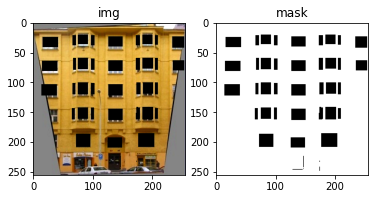

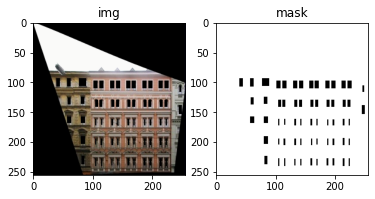

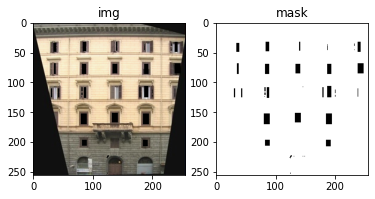

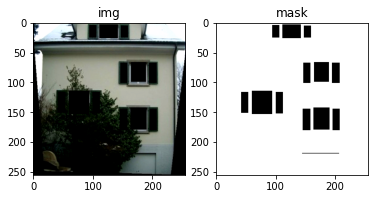

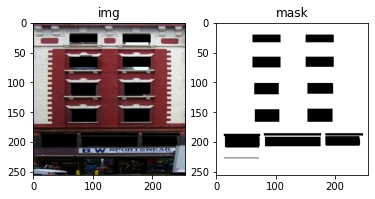

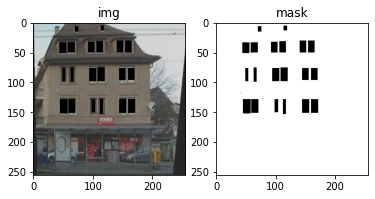

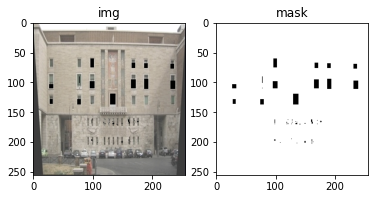

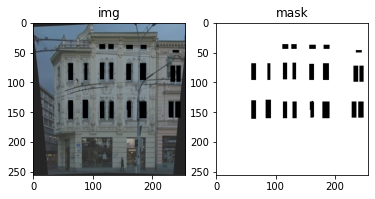

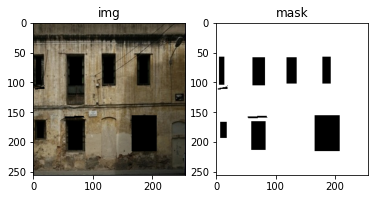

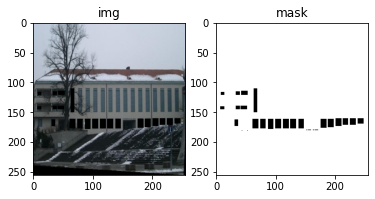

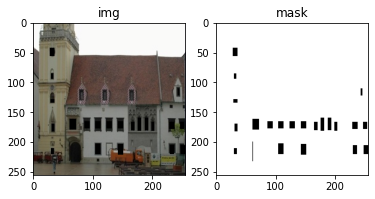

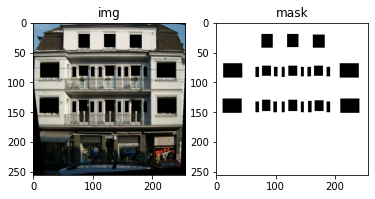

In [12]:
X, y = next(iter(train_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    show_mask(img, mask, mean=mean, std=std)
    
X, y = next(iter(val_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    show_mask(img, mask, mean=mean, std=std)

# Эксперименты

In [13]:
class FCN(nn.Module):
    def __init__(self, in_chanels, activation):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_chanels, 64, 3, padding=1), # 256 X 256
            nn.BatchNorm2d(64),
            activation,
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2) # 128 X 128
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 X 64
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32 X 32
         )
        self.up = nn.Upsample(scale_factor=8) # 256 X 256 
        self.conv = nn.Conv2d(256, 1, 1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.conv(x)
        x = self.up(x)
        return x
        

In [14]:
def rect_out(preds):
    p = preds.cpu().detach()
    p = (p > 0.5).numpy().astype("uint8")
    for i, img in enumerate(p):
        contours, _ = cv2.findContours(img, \
                                       cv2.RETR_EXTERNAL, \
                                       cv2.CHAIN_APPROX_SIMPLE)
        for con in contours:
            box = cv2.minAreaRect(con)
            box = np.intp(cv2.boxPoints(box))
            cv2.drawContours(img, [box], 0, (255,255,255), -1)
        p[i] = img
    return p

In [15]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, labels, smooth=1):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        labels = labels.view(-1)
        intersection = (preds * labels).sum()
        dice = ((2.0*intersection + smooth)/\
                    (preds.sum() + labels.sum() + smooth))
        return 1 - dice


In [16]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN(3, nn.LeakyReLU(inplace=True)).to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 2 476 481'

In [17]:
def train(model, criterion, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        for mode in ("train", "val"):
            if mode == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            epoch_loss = 0
            for i, (X, y) in enumerate(loader):
                X = X.to(device)
                y = y.to(device)

                if mode == "train":
                    optimizer.zero_grad()
                    preds = model(X).squeeze(1)
                    loss = criterion(preds, y)
                    loss.backward() 
                    optimizer.step()
                else:
                    with torch.no_grad():
                        preds = model(X).squeeze(1)
                        loss = criterion(preds, y)
                epoch_loss += loss.cpu().item()
            if mode == "train":
                scheduler.step(epoch_loss)
            print(f"{epoch}\t| {mode}\t| loss:\t{epoch_loss / len(loader)}")

In [18]:
train(model, criterion, optim, scheduler, 10)

0	| train	| loss:	0.6563683673739433
0	| val	| loss:	0.6021753221750259
1	| train	| loss:	0.4992032453417778
1	| val	| loss:	0.5354486376047134
2	| train	| loss:	0.4598264113068581
2	| val	| loss:	0.49484531581401825
3	| train	| loss:	0.4370025396347046
3	| val	| loss:	0.44525938034057616
4	| train	| loss:	0.43032037913799287
4	| val	| loss:	0.48921996653079985
5	| train	| loss:	0.4165231168270111
5	| val	| loss:	0.42749994099140165
6	| train	| loss:	0.40796400010585787
6	| val	| loss:	0.42115492522716524
7	| train	| loss:	0.40756467133760454
7	| val	| loss:	0.4954805731773376
8	| train	| loss:	0.3969202399253845
8	| val	| loss:	0.4211784929037094
9	| train	| loss:	0.3980434760451317
9	| val	| loss:	0.4157042682170868


In [21]:
def show_results(model):
    X, y = next(iter(val_loader))
    X = X.to(device)
    y = y.to(device)

    model.eval()
    preds = model(X).squeeze(1)
    pred = torch.sigmoid(preds).cpu().detach()
    # preds = rect_out(preds)
    for i in range(len(X)):
        show_mask(X[i].cpu().detach(), y[i].cpu(), pred[i], mean, std)
        print("accuracy: ", 1 - criterion(preds[i].cpu().detach(), y[i].cpu()).item())

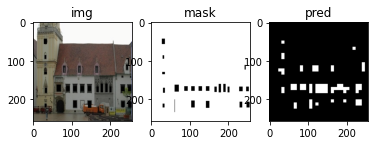

accuracy:  0.399042546749115


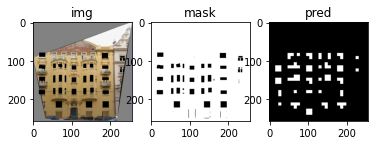

accuracy:  0.5052490234375


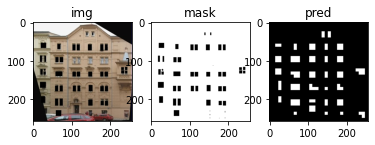

accuracy:  0.5744577646255493


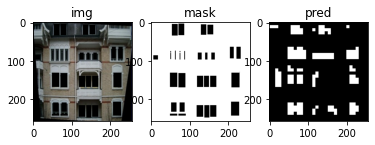

accuracy:  0.5298004746437073


In [22]:
show_results(model)

In [23]:
class FCNConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
        )
    
    def forward(self, x):
        return self.layer(x)

        
class FCNWithDecoder(nn.Module):
    def __init__(self, activation=nn.ReLU(inplace=True), upsample_mode="nearest"):
        super().__init__()
        self.inconv = FCNConvBlock(3, 64, activation)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode=upsample_mode)
        
        # Encoder
        self.down_list = nn.ModuleList([])
        for i in [64, 128, 256]:
            self.down_list.append(FCNConvBlock(i, i * 2, activation))
        
        # Decoder
        self.up_list = nn.ModuleList([])
        for i in [256, 128, 64, 32]:
            self.up_list.append(FCNConvBlock(i * 2, i, activation))
        
        # Classifier
        self.classifier = nn.Conv2d(32, 1, 1)
        
    def forward(self, x):
        x = self.inconv(x)
        x = self.pool(x)
        
        # Encoder 
        for down_layer in self.down_list:
            x = down_layer(x)
            x = self.pool(x)
        
        # Decoder
        for up_layer in self.up_list:
            x = up_layer(x)
            x = self.up(x)
        x = self.classifier(x)
        return x

In [24]:
torch.cuda.empty_cache()
model = FCNWithDecoder().to(device)
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 7 042 209'

In [25]:
train(model, criterion, optim, scheduler, 10)

0	| train	| loss:	0.6855820879340172
0	| val	| loss:	0.7154117733240127
1	| train	| loss:	0.564256851375103
1	| val	| loss:	0.5407810240983963
2	| train	| loss:	0.4710823714733124
2	| val	| loss:	0.5074608355760575
3	| train	| loss:	0.41686507910490034
3	| val	| loss:	0.45632053911685944
4	| train	| loss:	0.39621240347623826
4	| val	| loss:	0.4377216428518295
5	| train	| loss:	0.3714179560542107
5	| val	| loss:	0.4353249937295914
6	| train	| loss:	0.36006674021482465
6	| val	| loss:	0.3872683882713318
7	| train	| loss:	0.33787875175476073
7	| val	| loss:	0.37432716190814974
8	| train	| loss:	0.33380440026521685
8	| val	| loss:	0.3614446401596069
9	| train	| loss:	0.33027721345424654
9	| val	| loss:	0.36637220680713656


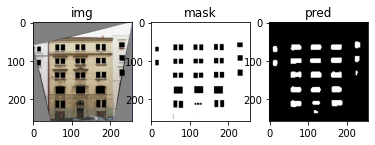

accuracy:  0.7711348533630371


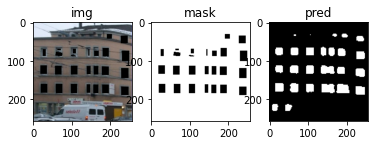

accuracy:  0.7155743837356567


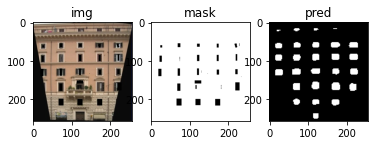

accuracy:  0.4222245216369629


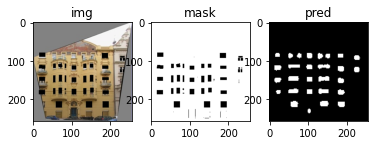

accuracy:  0.616410493850708


In [26]:
show_results(model)

In [27]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels,\
                 out_channels,\
                 stride=1,\
                 activation=nn.ReLU()):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, 3, stride, 1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
        )
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None
        self.act = activation
    
    
    def forward(self, x):
        identity = x
        x = self.layer(x)
        if self.down is not None:
            identity = self.down(identity)
        x += identity
        x = self.act(x)
        return x


    
class Resnet(nn.Module):
    def __init__(self, channels, layers, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.inconv = nn.Sequential(
            nn.Conv2d(3, channels, 7, 2, 3),
            nn.BatchNorm2d(channels),
            activation,
        )
        self.layer1 = self.make_layer(channels, channels, layers[0], 1, activation)
        self.layer2 = self.make_layer(channels, channels * 2, layers[1], 2, activation)
        self.layer3 = self.make_layer(channels * 2, channels * 4, layers[2], 2, activation)
        self.layer4 = self.make_layer(channels * 4, channels * 8, layers[3], 2, activation)
        
        self.outconv = nn.Sequential(
            nn.Upsample(scale_factor=16),
            nn.Conv2d(channels * 8, 1, 1)
        )
    
    
    def make_layer(self, in_channels, out_channels, layers, stride, activation):
        out = [ResnetBlock(in_channels, out_channels, stride, activation)]
        for _ in range(1, layers):
            out.append(ResnetBlock(out_channels, out_channels, activation=activation))
        out = nn.Sequential(*out)
        return out
    
    
    def forward(self, x):
        x = self.inconv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.outconv(x)
        return x
    

In [28]:
torch.cuda.empty_cache()
model = Resnet(64, [3, 4, 6, 3]).to(device)
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 13 878 977'

In [29]:
train(model, criterion, optim, scheduler, 10)

0	| train	| loss:	0.677992969751358
0	| val	| loss:	0.7254947185516357
1	| train	| loss:	0.5891903340816498
1	| val	| loss:	0.6310705810785293
2	| train	| loss:	0.5609209731221199
2	| val	| loss:	0.5831302911043167
3	| train	| loss:	0.5448308184742927
3	| val	| loss:	0.588834461569786
4	| train	| loss:	0.5362391099333763
4	| val	| loss:	0.571677166223526
5	| train	| loss:	0.5231093823909759
5	| val	| loss:	0.5615051746368408
6	| train	| loss:	0.5221083253622055
6	| val	| loss:	0.5536225438117981
7	| train	| loss:	0.5117600813508034
7	| val	| loss:	0.5414848983287811
8	| train	| loss:	0.5125785887241363
8	| val	| loss:	0.5452890366315841
9	| train	| loss:	0.5162932366132736
9	| val	| loss:	0.5470038801431656


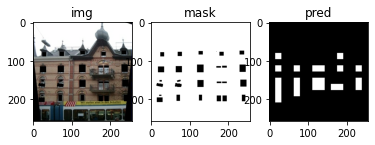

accuracy:  0.42175257205963135


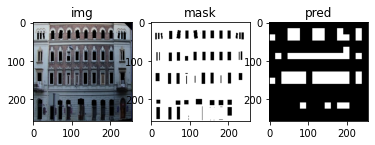

accuracy:  0.38446497917175293


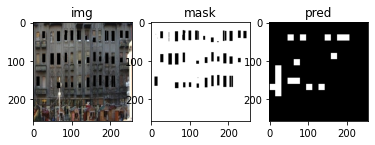

accuracy:  0.16159361600875854


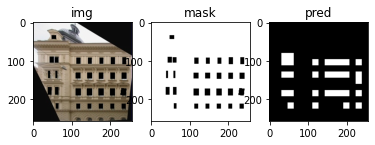

accuracy:  0.49099934101104736


In [30]:
show_results(model)

In [31]:
class UnetConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=None):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    
    def forward(self, x):
        return self.layer(x)



class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation, inblock=None):
        super().__init__()
        self.inconv = nn.Sequential(
            UnetConvBlock(in_channels, out_channels, activation),
            UnetConvBlock(out_channels, out_channels, activation)
        )
        self.pool = nn.MaxPool2d(2, 2)
        
        if inblock:
            self.inblock = inblock
        else:
            self.inblock = nn.Sequential(
                UnetConvBlock(out_channels, out_channels, activation),
                UnetConvBlock(out_channels, out_channels, activation)
            )
        
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.upconv = UnetConvBlock(out_channels, in_channels, activation)
        
        self.outconv = nn.Sequential(
            UnetConvBlock(in_channels + out_channels, in_channels, activation),
            UnetConvBlock(in_channels, in_channels, activation),
        )
    
    
    def forward(self, x):
        inconv = self.inconv(x)
        x = self.pool(inconv)
        
        x = self.inblock(x)
        
        x = self.up(x)
        x = self.upconv(x)
        x = torch.cat((inconv, x), dim=1)
        
        x = self.outconv(x)
        return x
        
        
        
class Unet(nn.Module):
    def __init__(self, channels=64, depth=3, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.inconv = nn.Sequential(
            UnetConvBlock(3, channels, activation),
            UnetConvBlock(channels, channels, activation),
        )
        
        if depth > 10 or depth < 2 or channels % 2 != 0:
            raise ValueError("depth shuld be less than " + \
                             "10 and greater then 1 " +\
                             "and channels should be 2**n")
        n = channels * 2 ** (depth - 1)
        block = UnetBlock(n // 2, n, activation)
        n = n // 2
        while n > channels:
            block = UnetBlock(n // 2, n, activation, block)
            n = n // 2
        self.block = block
        
        self.outconv = nn.Sequential(
            UnetConvBlock(channels, channels, activation),
            nn.Conv2d(channels, 1, 1)
        )
    
    
    def forward(self, x):
        x = self.inconv(x)
        x = self.block(x)
        x = self.outconv(x)
        return x
        

In [32]:
torch.cuda.empty_cache()
model = Unet(64, 4).to(device)
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 14 096 897'

In [33]:
train(model, criterion, optim, scheduler, 10)

0	| train	| loss:	0.7010733723640442
0	| val	| loss:	0.8086912214756012
1	| train	| loss:	0.5671258091926574
1	| val	| loss:	0.6007816374301911
2	| train	| loss:	0.449433870613575
2	| val	| loss:	0.47472344636917113
3	| train	| loss:	0.38844928741455076
3	| val	| loss:	0.4383023649454117
4	| train	| loss:	0.3529923304915428
4	| val	| loss:	0.37093497812747955
5	| train	| loss:	0.32788233906030656
5	| val	| loss:	0.37427200973033903
6	| train	| loss:	0.32015317380428315
6	| val	| loss:	0.37626199424266815
7	| train	| loss:	0.31388270705938337
7	| val	| loss:	0.34960685968399047
8	| train	| loss:	0.304151625931263
8	| val	| loss:	0.3299237072467804
9	| train	| loss:	0.30291789323091506
9	| val	| loss:	0.32648037672042846


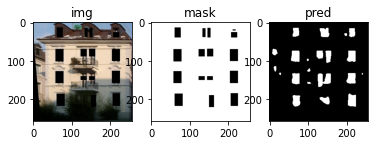

accuracy:  0.7351357340812683


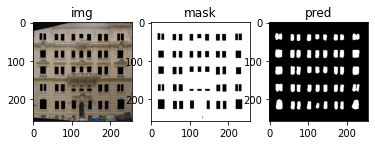

accuracy:  0.8330807685852051


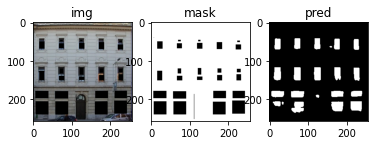

accuracy:  0.7237222790718079


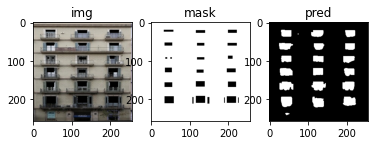

accuracy:  0.5130719542503357


In [34]:
show_results(model)